## 🎯 Objective

> ### Problem Statement:  
"How can we accurately predict delivery time (`Delivery_Time_min`) based on factors such as distance, weather, traffic level, time of day, vehicle type, preparation time, and courier experience?"

> ### Business Insight:  
- Help food delivery platforms provide more accurate delivery estimates.  
- Improve customer satisfaction through better predictions.  
- Optimize resource management (e.g., courier allocation).


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

> ### Preview first 5 rows of the dataset

In [123]:
df = pd.read_csv("Food_Delivery_Times.csv")
print("Dataset Preview:")
df.head()

Dataset Preview:


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


> ### Descriptive statistics for numerical columns

In [124]:
print("\nDescriptive Statistics:")
df.describe()


Descriptive Statistics:


,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


> ### Dataset information including data types and missing values

In [125]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


> ### Dataset Overview
The dataset consists of 1000 entries and 9 columns:
- `Order_ID`: Unique identifier for each order.
- `Distance_km`: The delivery distance in kilometers.
- `Weather`: Weather conditions during the delivery, including Clear, Rainy, Snowy, Foggy, and Windy.
- `Traffic_Level`: Traffic conditions categorized as Low, Medium, or High.
- `Time_of_Day`: The time when the delivery took place, categorized as Morning, Afternoon, Evening, or Night.
- `Vehicle_Type`: Type of vehicle used for delivery, including Bike, Scooter, and Car.
- `Preparation_Time_min`: The time required to prepare the order, measured in minutes.
- `Courier_Experience_yrs`: Experience of the courier in years.
- `Delivery_Time_min`: The total delivery time in minutes (target variable).

> ### Count missing values in each column

In [126]:
print("\nMissing Values per Column:")
df.isnull().sum()


Missing Values per Column:


Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

> Since these missing values are in categorical and numerical columns, typical handling methods include:

- For categorical columns (Weather, Traffic_Level, Time_of_Day):

    - Impute missing values with the most frequent category (mode), or

    - Use a new category like 'Unknown' if appropriate

- For numerical column (Courier_Experience_yrs):

    - Impute missing values using mean or median, depending on distribution

    - Alternatively, if missing is large, consider more advanced methods or dropping rows (but since only 30 rows, imputation preferred)

In [127]:
# Check mode for categorical columns
df[['Weather', 'Traffic_Level', 'Time_of_Day']].mode()

for col in ['Weather', 'Traffic_Level', 'Time_of_Day']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

# Impute numerical column with median
median_exp = df['Courier_Experience_yrs'].median()
df['Courier_Experience_yrs'] = df['Courier_Experience_yrs'].fillna(median_exp)

# Verify no missing values remain
print("\nMissing Values after Imputation:")
print(df.isnull().sum())


Missing Values after Imputation:
Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


The dataset are safe from missing value :)

> ### Drop **order_id** because it's not used in this project

In [128]:
# Drop the Order_ID column as it is not useful for prediction
df = df.drop(columns=['Order_ID'])

# Verify the column is dropped
print("Columns after dropping Order_ID:")
df.head()


Columns after dropping Order_ID:


,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68


> ### Check duplicated data

In [129]:
len(df.drop_duplicates()) / len(df)

1.0

- The dataset are safe from duplicated data

> ### Check Unique Values

In [130]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


> ### Target Distribution

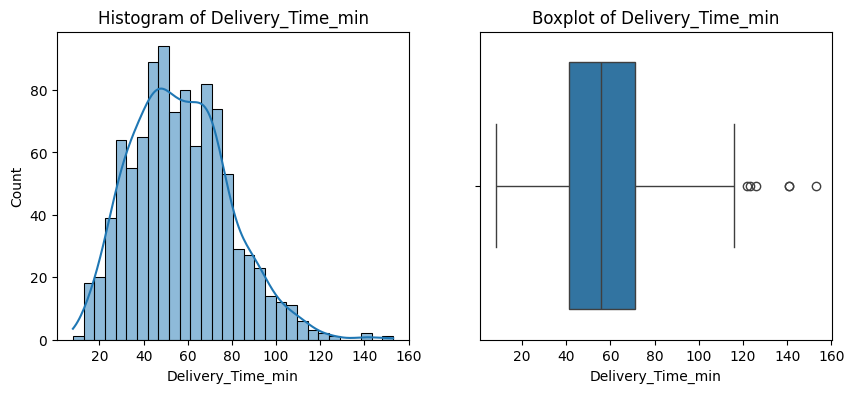

Summary statistics of Delivery_Time_min:
count    1000.000000
mean       56.732000
std        22.070915
min         8.000000
25%        41.000000
50%        55.500000
75%        71.000000
max       153.000000
Name: Delivery_Time_min, dtype: float64
Skewness: 0.507
Kurtosis: 0.291


In [131]:


plt.figure(figsize=(10,4))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df['Delivery_Time_min'], bins=30, kde=True)
plt.title('Histogram of Delivery_Time_min')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df['Delivery_Time_min'])
plt.title('Boxplot of Delivery_Time_min')

plt.show()

# Summary statistics
print("Summary statistics of Delivery_Time_min:")
print(df['Delivery_Time_min'].describe())
print(f"Skewness: {df['Delivery_Time_min'].skew():.3f}")
print(f"Kurtosis: {df['Delivery_Time_min'].kurtosis():.3f}")


> ### Conclusion of Delivery_Time_min Distribution Analysis

- Distribution Shape
    - The histogram shows a roughly symmetric distribution with a slight right skew (positive skewness of 0.507), indicating that most delivery times are clustered around the mean, but there are some longer delivery times extending the tail to the right.  
    - The kurtosis value of 0.291 suggests a distribution with lighter tails and a flatter peak compared to a normal distribution (mesokurtic).

- Central Tendency and Spread
    - The mean delivery time is approximately 56.7 minutes, and the median is 55.5 minutes, which are close, further supporting the near-symmetric distribution.  
    - The standard deviation is 22.1 minutes, indicating moderate variability in delivery times.

- Range and Outliers
    - The minimum delivery time is 8 minutes, and the maximum is 153 minutes.  
    - The boxplot shows a few potential outliers on the higher end (right side), suggesting some unusually long delivery times.

- Practical Implications
    - Most deliveries (50%) are completed between 41 minutes (Q1) and 71 minutes (Q3).  
    - The slight right skew and outliers suggest occasional delays, which may warrant investigation into their causes (e.g., traffic, distance, or operational inefficiencies).


> ### Data Manipulation, Feature Engineering
### `Encoding Categorical Variables Explanation`

- Categorical Columns  
    - Weather  
    - Traffic_Level  
    - Time_of_Day  
    - Vehicle_Type  

- Encoding Method: One-Hot Encoding  
    - Suitable for nominal categorical variables without intrinsic order.  
    - Converts each category into a separate binary (0/1) column.  
    - Avoids implying any ordinal relationship between categories.  
    - `drop_first=True` avoids multicollinearity by dropping one category per feature.

- Result  
    - The dataset becomes fully numeric and ready for machine learning models.  
    - Increases the number of columns but preserves all category information.

- Implementation  
    - Using `pandas.get_dummies()` for simplicity and efficiency.  
    - This method automatically handles all specified categorical columns.


In [132]:
# Perform One-Hot Encoding on all categorical columns WITHOUT dropping any category
df_encoded = pd.get_dummies(
    df,
    columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'],
    drop_first=False  # Keep all categories explicitly
)

# Show all column names after encoding
print("Columns after encoding:")
df_encoded.columns.tolist()

Columns after encoding:


['Distance_km',
 'Preparation_Time_min',
 'Courier_Experience_yrs',
 'Delivery_Time_min',
 'Weather_Clear',
 'Weather_Foggy',
 'Weather_Rainy',
 'Weather_Snowy',
 'Weather_Windy',
 'Traffic_Level_High',
 'Traffic_Level_Low',
 'Traffic_Level_Medium',
 'Time_of_Day_Afternoon',
 'Time_of_Day_Evening',
 'Time_of_Day_Morning',
 'Time_of_Day_Night',
 'Vehicle_Type_Bike',
 'Vehicle_Type_Car',
 'Vehicle_Type_Scooter']

In [133]:
# Preview the first few rows of the encoded dataframe
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [134]:
for col in ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']:
    print(f"\nUnique values in {col}:")
    print(df[col].dropna().unique())


Unique values in Weather:
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy']

Unique values in Traffic_Level:
['Low' 'Medium' 'High']

Unique values in Time_of_Day:
['Afternoon' 'Evening' 'Night' 'Morning']

Unique values in Vehicle_Type:
['Scooter' 'Bike' 'Car']


> ### Split dataset

In [135]:
from sklearn.model_selection import train_test_split

# Define feature and target variables explicitly
feature = df_encoded.drop(columns=['Delivery_Time_min'])
target = df_encoded[['Delivery_Time_min']]

# Split dataset into training and testing sets (80% train, 20% test)
feature_train, feature_test, target_train, target_test = train_test_split(
    feature, target, test_size=0.2, random_state=42
)

# Print the shapes of the resulting datasets
print(f"Training features shape: {feature_train.shape}")
print(f"Testing features shape: {feature_test.shape}")
print(f"Training target shape: {target_train.shape}")
print(f"Testing target shape: {target_test.shape}")


Training features shape: (800, 18)
Testing features shape: (200, 18)
Training target shape: (800, 1)
Testing target shape: (200, 1)


> #### Check the outlier

In [136]:
import scipy.stats as stats

def check_plot(x_train, variable):
    # fungsi mengambil kerangka data (df) dan
    # variabel yang diminati sebagai argumen

    # tentukan ukuran gambar
    plt.figure(figsize=(16, 4))


    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=x_train[variable])
    plt.title('Boxplot')

    plt.show()

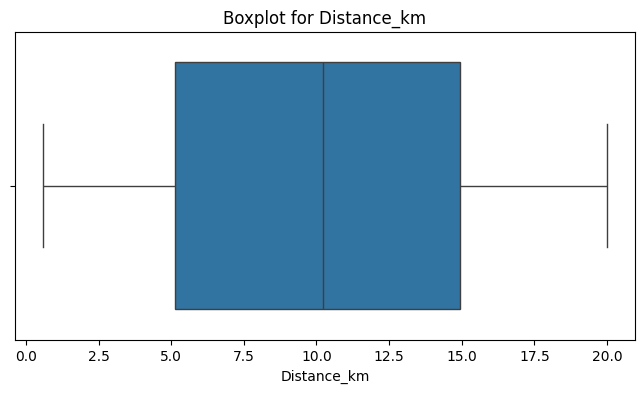

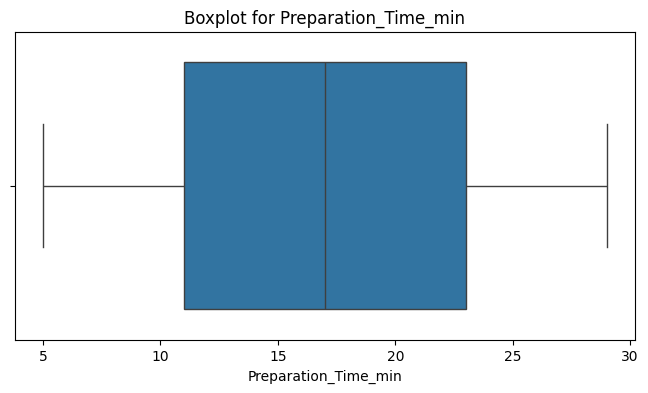

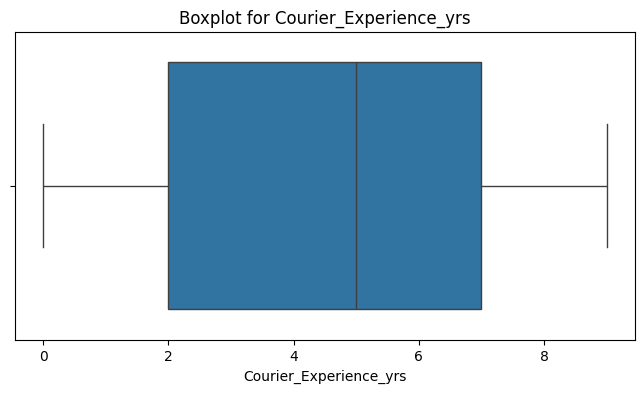

In [137]:
# List of numeric columns from feature_train
numeric_columns = feature_train.select_dtypes(include=['number']).columns

# Columns relevant for outlier checking in your project
# Adjust this list to your dataset's numeric features
columns_to_check = ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']

def check_plot(data, col):
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

# Loop through numeric columns and plot boxplots for selected features
for col in numeric_columns:
    if col in columns_to_check:
        check_plot(feature_train, col)

- There are no Outliers

> ### Scalling

In [138]:
df_encoded.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Weather_Clear,Weather_Foggy,Weather_Rainy,Weather_Snowy,Weather_Windy,Traffic_Level_High,Traffic_Level_Low,Traffic_Level_Medium,Time_of_Day_Afternoon,Time_of_Day_Evening,Time_of_Day_Morning,Time_of_Day_Night,Vehicle_Type_Bike,Vehicle_Type_Car,Vehicle_Type_Scooter
0,7.93,12,1.0,43,False,False,False,False,True,False,True,False,True,False,False,False,False,False,True
1,16.42,20,2.0,84,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False
2,9.52,28,1.0,59,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True
3,7.44,5,1.0,37,False,False,True,False,False,False,False,True,True,False,False,False,False,False,True
4,19.03,16,5.0,68,True,False,False,False,False,False,True,False,False,False,True,False,True,False,False


In [139]:
scaler = MinMaxScaler()

# Fit scaler on training features
scaler.fit(feature_train)

# Transform training and testing features
X_train_scaled = scaler.transform(feature_train)
X_test_scaled = scaler.transform(feature_test)

# Optional: convert back to DataFrame with original columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_train.columns, index=feature_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_test.columns, index=feature_test.index)

> ### Model Training and Evaluation

- #### Recommended Models for Delivery Time Prediction

    - Based on recent studies and practical considerations, we focus on three strong candidate models for predicting delivery time:

    1. **XGBoost (XGBRegressor)[1]**
        - XGBoost demonstrated the best performance in predicting food delivery times with an R² of 0.82 and low MAE and RMSE, effectively capturing complex patterns in the data.
        - Important features like weather, traffic, and courier profile are well handled by this ensemble method.
        - **Conclusion:** XGBoost is highly recommended for logistic or food delivery time prediction projects.
        - Reference: https://www.researchgate.net/publication/382020188_A_Comparative_Analysis_of_Machine_Learning_Models_for_Time_Prediction_in_Food_Delivery_Operations

    2. **LightGBM**
        - In a study on food delivery time prediction in Indian cities, LightGBM outperformed Random Forest and XGBoost statistically, with an R² of 0.76.
        - It is especially suitable when model speed and efficiency are priorities.
        - **Conclusion:** LightGBM is competitive and recommended for optimizing prediction speed and resource usage.
        - Reference: https://arxiv.org/html/2503.15177v1

    3. **Random Forest**
        - Random Forest has been used effectively for delivery time prediction with average accuracy around 83.86% depending on implementation.
        - Known for its flexibility and ease of use on various data types, it offers stable and interpretable results.
        - **Conclusion:** Random Forest remains a good choice for stable and interpretable models.
        - Reference: https://ijadis.org/index.php/ijadis/article/view/1281


- #### Model Candidates for This Project
    - XGBoost (XGBRegressor)
    - LightGBM
    - Random Forest

> ### Model Performance Evaluation Overview

- We will evaluate the performance of several regression models on the delivery time prediction task:
  - **Before hyperparameter tuning:** Using default model settings.
  - **After hyperparameter tuning:** Optimizing key parameters to improve accuracy.

- The main metrics to assess model performance will be:
  - **R-squared (R²):** Proportion of variance explained by the model. Higher is better.
  - **Mean Absolute Error (MAE):** Average absolute difference between predicted and actual values. Lower is better.
  - **Root Mean Squared Error (RMSE):** Square root of average squared differences. Penalizes larger errors more. Lower is better.

- After evaluation, we will compare metrics to select the best performing model.


> ### Before Hyperparameter Tuning

In [140]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy as np

# Function to train, predict, and evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Model: {model.__class__.__name__}")
    print(f"R²: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}\n")
    return r2, mae, rmse

# Instantiate models with default hyperparameters
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

print("### Performance Before Hyperparameter Tuning ###\n")
evaluate_model(xgb, feature_train, target_train, feature_test, target_test)
evaluate_model(lgbm, feature_train, target_train, feature_test, target_test)
evaluate_model(rf, feature_train, target_train, feature_test, target_test)


### Performance Before Hyperparameter Tuning ###

Model: XGBRegressor
R²: 0.7361
MAE: 7.8191
RMSE: 10.8767

Model: LGBMRegressor
R²: 0.7826
MAE: 7.1197
RMSE: 9.8706

Model: RandomForestRegressor
R²: 0.7908
MAE: 6.8453
RMSE: 9.6827



(0.7908342319201114, 6.84535, 9.682651470542561)

> ### Interpretation of Model Performance Before Hyperparameter Tuning

- **Random Forest Regressor** shows the best initial performance with:
  - Highest R²: 0.7908 (explains ~79% of variance)
  - Lowest MAE: 6.8453 (smallest average error in minutes)
  - Lowest RMSE: 9.6827 (better penalty on large errors)

- **LightGBM Regressor** performs well, slightly behind Random Forest:
  - R²: 0.7826
  - MAE: 7.1197
  - RMSE: 9.8706

- **XGBoost Regressor** has the lowest performance among the three but still respectable:
  - R²: 0.7361
  - MAE: 7.8191
  - RMSE: 10.8767

---

- These results suggest **Random Forest** as the best baseline model so far.
- However, all models can likely improve with hyperparameter tuning.
- Next step is to tune these models to optimize their predictive accuracy.


> ### Approach for Hyperparameter Tuning and Model Comparison

- We will perform hyperparameter tuning **separately for each model** (XGBoost, LightGBM, Random Forest) to find their best parameter settings individually.
- After tuning each model, we will evaluate their performance on the test set.
- Finally, we will compare:
  - The best tuned model performances against each other.
  - Each tuned model versus its default (untuned) version.
- This stepwise approach helps us select the **best performing model and configuration** for the delivery time prediction task.

---

### Plan
1. Tune **XGBoost** hyperparameters and evaluate.  
2. Tune **LightGBM** hyperparameters and evaluate.  
3. Tune **Random Forest** hyperparameters and evaluate.  
4. Compare all tuned models and their default counterparts.  
5. Decide on the best model and whether tuning significantly improves performance.

---


> ### Hyperparameter Tuning for XGBoost (Step 1)

- We will start by tuning the **XGBoost Regressor** hyperparameters using `RandomizedSearchCV`.
- This will help us find the best combination of parameters to improve prediction accuracy.
- We use 5-fold cross-validation and optimize for R² score.


In [142]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
}

# Initialize XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Setup RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
xgb_search.fit(feature_train, target_train.values.ravel())

# Print best parameters and best score
print("Best parameters found for XGBoost:")
print(xgb_search.best_params_)
print(f"Best CV R² score: {xgb_search.best_score_:.4f}")

# Evaluate tuned model on test set
best_xgb = xgb_search.best_estimator_
y_pred = best_xgb.predict(feature_test)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2 = r2_score(target_test, y_pred)
mae = mean_absolute_error(target_test, y_pred)
rmse = np.sqrt(mean_squared_error(target_test, y_pred))

print("\nPerformance of Tuned XGBoost on Test Data:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found for XGBoost:
{'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01}
Best CV R² score: 0.7313

Performance of Tuned XGBoost on Test Data:
R²: 0.8044
MAE: 6.5591
RMSE: 9.3636


> ### Hyperparameter Tuning for LightGBM (Step 2)

- Next, we tune the **LightGBM Regressor** hyperparameters using `RandomizedSearchCV`.
- The goal is to find the best parameter combination that maximizes R² score using 5-fold cross-validation.


In [143]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Define parameter grid for LightGBM
lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15, -1],
}

# Initialize LightGBM Regressor
lgbm = LGBMRegressor(random_state=42)

# Setup RandomizedSearchCV for LightGBM
lgbm_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
lgbm_search.fit(feature_train, target_train.values.ravel())

# Print best parameters and best score
print("Best parameters found for LightGBM:")
print(lgbm_search.best_params_)
print(f"Best CV R² score: {lgbm_search.best_score_:.4f}")

# Evaluate tuned model on test set
best_lgbm = lgbm_search.best_estimator_
y_pred_lgbm = best_lgbm.predict(feature_test)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2_lgbm = r2_score(target_test, y_pred_lgbm)
mae_lgbm = mean_absolute_error(target_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mean_squared_error(target_test, y_pred_lgbm))

print("\nPerformance of Tuned LightGBM on Test Data:")
print(f"R²: {r2_lgbm:.4f}")
print(f"MAE: {mae_lgbm:.4f}")
print(f"RMSE: {rmse_lgbm:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found for LightGBM:
{'num_leaves': 31, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05}
Best CV R² score: 0.7209

Performance of Tuned LightGBM on Test Data:
R²: 0.8017
MAE: 6.7256
RMSE: 9.4273


> ### Hyperparameter Tuning for Random Forest (Step 3)

- Finally, we tune the **Random Forest Regressor** hyperparameters using `RandomizedSearchCV`.
- The goal is to optimize the model for best R² score using 5-fold cross-validation.


In [144]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Initialize Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV for Random Forest
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
rf_search.fit(feature_train, target_train.values.ravel())

# Print best parameters and best score
print("Best parameters found for Random Forest:")
print(rf_search.best_params_)
print(f"Best CV R² score: {rf_search.best_score_:.4f}")

# Evaluate tuned model on test set
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(feature_test)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

r2_rf = r2_score(target_test, y_pred_rf)
mae_rf = mean_absolute_error(target_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(target_test, y_pred_rf))

print("\nPerformance of Tuned Random Forest on Test Data:")
print(f"R²: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 666, in

Best parameters found for Random Forest:
{'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': None}
Best CV R² score: 0.6876

Performance of Tuned Random Forest on Test Data:
R²: 0.7811
MAE: 7.4765
RMSE: 9.9061


> ### Analysis of Model Performance After Hyperparameter Tuning

- **Tuned XGBoost Regressor**  
  - R²: 0.8044 (improved from 0.7361)  
  - MAE: 6.5591 (improved from 7.8191)  
  - RMSE: 9.3636 (improved from 10.8767)  
  - Significant improvement across all metrics; strongest performer after tuning.

- **Tuned LightGBM Regressor**  
  - R²: 0.8017 (improved from 0.7826)  
  - MAE: 6.7256 (improved from 7.1197)  
  - RMSE: 9.4273 (improved from 9.8706)  
  - Also shows meaningful gains; very competitive with XGBoost.

- **Tuned Random Forest Regressor**  
  - R²: 0.7811 (slightly decreased from 0.7908 before tuning)  
  - MAE: 7.4765 (worse than 6.8453 before tuning)  
  - RMSE: 9.9061 (slightly worse than 9.6827 before tuning)  
  - Tuning did not improve Random Forest performance; default was better.

---

### Overall Comparison and Recommendation

| Model          | R² Before | R² After | MAE Before | MAE After | RMSE Before | RMSE After |
|----------------|-----------|----------|------------|-----------|-------------|------------|
| XGBoost        | 0.7361    | 0.8044   | 7.8191     | 6.5591    | 10.8767     | 9.3636     |
| LightGBM       | 0.7826    | 0.8017   | 7.1197     | 6.7256    | 9.8706      | 9.4273     |
| Random Forest  | 0.7908    | 0.7811   | 6.8453     | 7.4765    | 9.6827      | 9.9061     |

- Both **XGBoost** and **LightGBM** benefited significantly from hyperparameter tuning, improving their predictive accuracy and error metrics.  
- **Random Forest** performed better with default parameters, and tuning slightly degraded its performance.  
- Among all, **tuned XGBoost** achieved the best R² and lowest error values, making it the recommended model for this project.

---

### Decision

- Proceed with **tuned XGBoost** as the main prediction model.  
- Consider model interpretation (feature importance), residual analysis, and deployment planning.  
- Optionally, further fine-tune or ensemble models if desired.

### Before we move to next step, let's do feature importance first.
---


> ### Feature Importance for All Tuned Models

- To compare feature importance across models, we will plot the top features for:  
  - Tuned XGBoost  
  - Tuned LightGBM  
  - Tuned Random Forest

- This helps us understand which features each model finds most influential in predicting delivery time.



In [150]:
def feature_importance_table(model, feature_names, top_n=15):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)
    return importance_df

# Generate tables for all three models
xgb_imp_df = feature_importance_table(best_xgb, feature_train.columns)
lgbm_imp_df = feature_importance_table(best_lgbm, feature_train.columns)
rf_imp_df = feature_importance_table(best_rf, feature_train.columns)

In [153]:
print("XGBoost Feature Importance:")
print(xgb_imp_df.to_string(index=False))

print("\nLightGBM Feature Importance:")
print(lgbm_imp_df.to_string(index=False))

print("\nRandom Forest Feature Importance:")
print(rf_imp_df.to_string(index=False))

XGBoost Feature Importance:
               Feature  Importance
           Distance_km    0.365881
  Preparation_Time_min    0.091437
     Traffic_Level_Low    0.056776
    Traffic_Level_High    0.056768
         Weather_Clear    0.049121
Courier_Experience_yrs    0.042637
         Weather_Snowy    0.041630
 Time_of_Day_Afternoon    0.036540
   Time_of_Day_Evening    0.035800
      Vehicle_Type_Car    0.035293
         Weather_Foggy    0.032911
         Weather_Rainy    0.030905
   Time_of_Day_Morning    0.025576
     Vehicle_Type_Bike    0.025230
  Vehicle_Type_Scooter    0.022952

LightGBM Feature Importance:
               Feature  Importance
           Distance_km         928
  Preparation_Time_min         631
Courier_Experience_yrs         414
     Traffic_Level_Low         176
         Weather_Clear         166
     Vehicle_Type_Bike         117
    Traffic_Level_High          96
         Weather_Snowy          45
 Time_of_Day_Afternoon          45
   Time_of_Day_Morning          

> ### Top 3 Feature Importance per Model

| Rank | XGBoost Feature       | Importance | LightGBM Feature        | Importance | Random Forest Feature     | Importance |
|-------|-----------------------|------------|------------------------|------------|--------------------------|------------|
| 1     | Distance_km           | 0.3659     | Distance_km            | 928        | Distance_km              | 0.5557     |
| 2     | Preparation_Time_min  | 0.0914     | Preparation_Time_min   | 631        | Preparation_Time_min     | 0.1637     |
| 3     | Traffic_Level_Low     | 0.0568     | Courier_Experience_yrs | 414        | Courier_Experience_yrs   | 0.0733     |

---

> ### Explanation

- **Distance_km** is the top predictor for all three models, indicating delivery distance heavily impacts delivery time.
- **Preparation_Time_min** consistently ranks second, highlighting the influence of order preparation duration.
- The third important feature varies:  
  - XGBoost emphasizes **Traffic_Level_Low**, showing traffic conditions affect delivery time.  
  - LightGBM and Random Forest prioritize **Courier_Experience_yrs**, suggesting courier experience also plays a significant role.
- These differences provide complementary perspectives on factors influencing delivery time.


----

> ### Deployment


In [155]:
import joblib

# Save trained XGBoost model
joblib.dump(best_xgb, 'xgb_tuned_model.pkl')

# Save scaler used on numeric features (assuming you have a scaler object)
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [156]:
df.head()

,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,19.03,Clear,Low,Morning,Bike,16,5.0,68
